<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_Disease_Reconization_Using_CNN_Models_ResNet101_code%26_Resnet_152_%26_Dense_169_%2B_VGG19_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! unzip ocular-disease-recognition-odir5k

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [3]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## **ResNet-101**

0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
594 600


100%|██████████| 594/594 [00:02<00:00, 222.32it/s]


588


100%|██████████| 600/600 [00:02<00:00, 258.45it/s]


1188


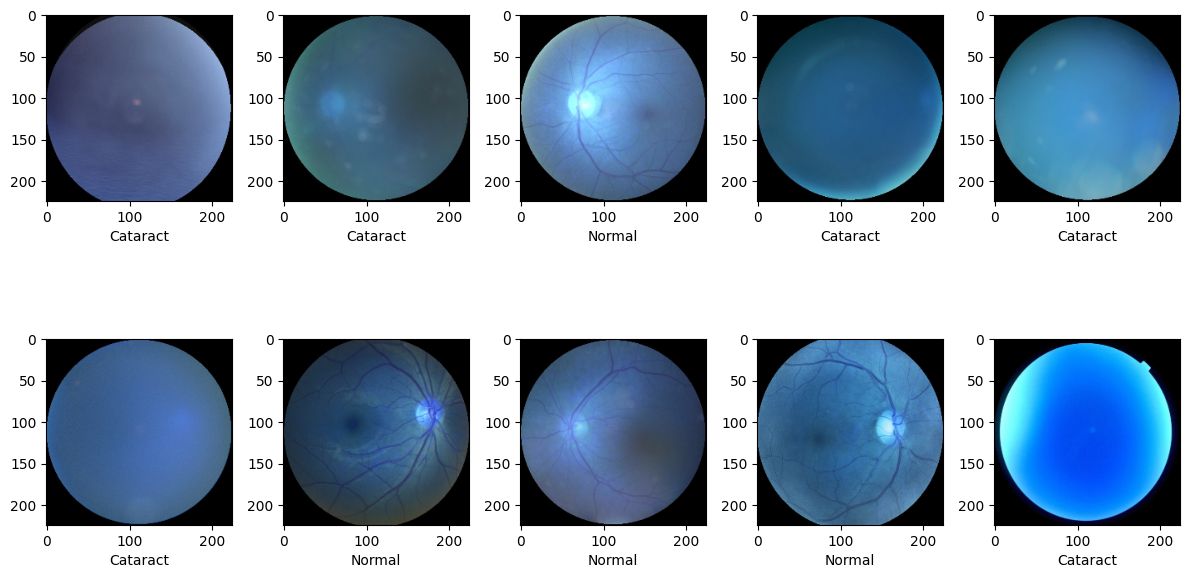

In [4]:
# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Load the pre-trained ResNet-101 model
from tensorflow.keras.applications import ResNet101

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.save("model_name.h5")

from tensorflow.keras.models import load_model
resnet = load_model('model_name.h5')

# Create a new model based on ResNet-101
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])

171446536/171446536 [==============================] - 2s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,348,801
Trainable params: 68,243,457
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/20
30/30 [====================

In [8]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 152ms/step - loss: 0.2235 - accuracy: 0.9454
Test Loss: 0.22351796925067902
Test Accuracy: 0.9453781247138977


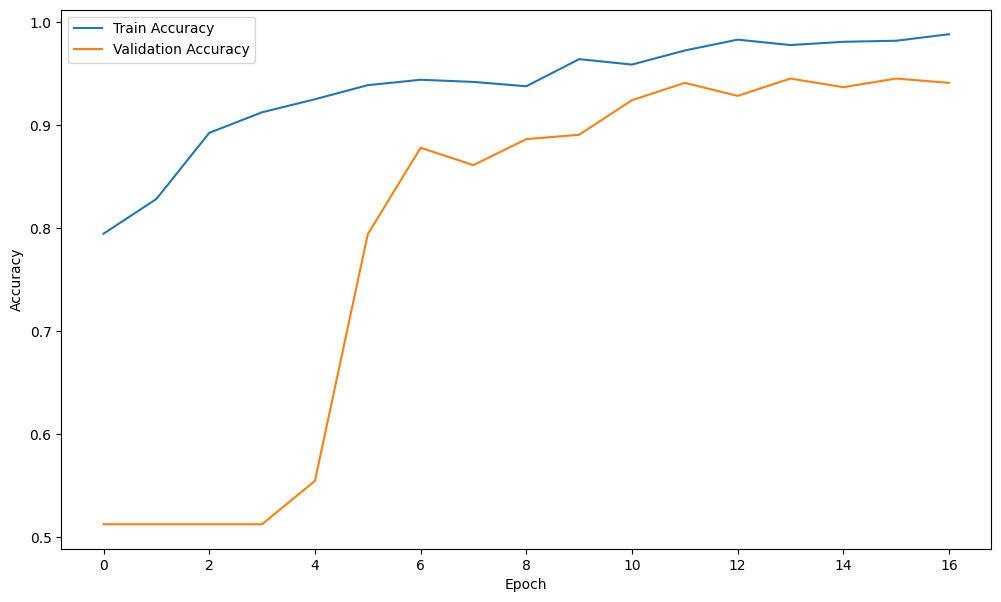

In [9]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

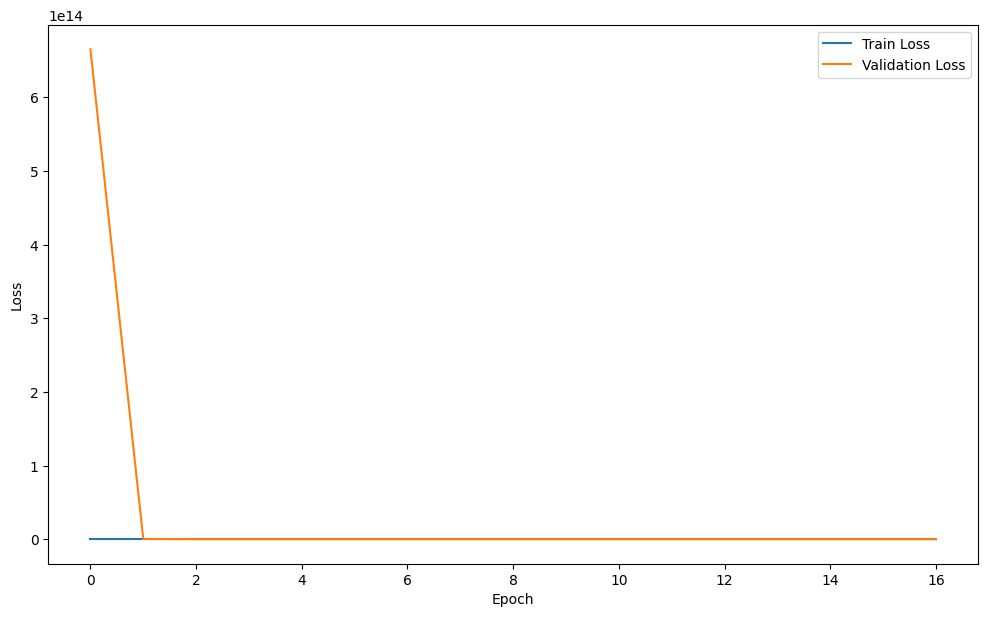

In [10]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

8/8 [==============================] - 3s 159ms/step


In [12]:
# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

In [13]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

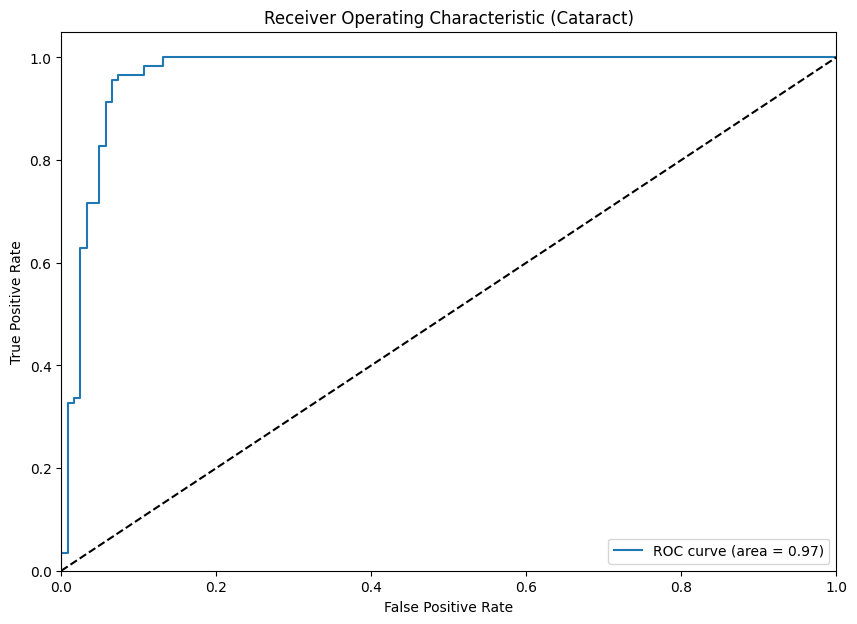

In [14]:
# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.96      0.93      0.95       122
    Cataract       0.93      0.96      0.94       116

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



In [16]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 152ms/step - loss: 0.2235 - accuracy: 0.9454
Test Loss: 0.22351796925067902
Test Accuracy: 0.9453781247138977


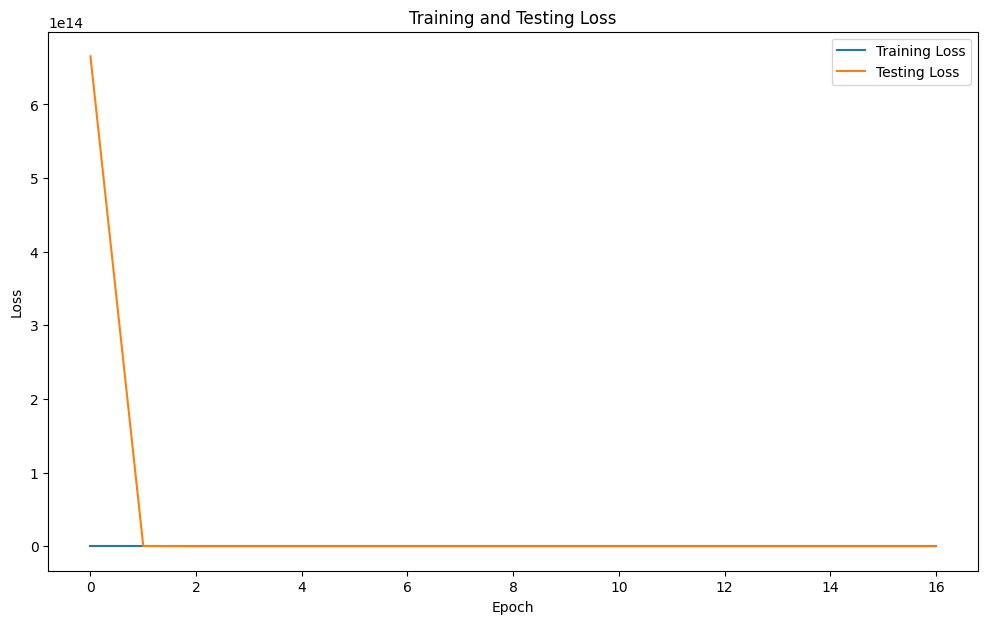

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

## **ResNet-152**

In [5]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained ResNet-152 model
resnet = ResNet152(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on ResNet-152
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 84,061,569
Trainable params: 83,910,145
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/20
30/30 [====================

In [6]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 2s 215ms/step - loss: 0.5434 - accuracy: 0.9202
Test Loss: 0.5433814525604248
Test Accuracy: 0.9201680421829224


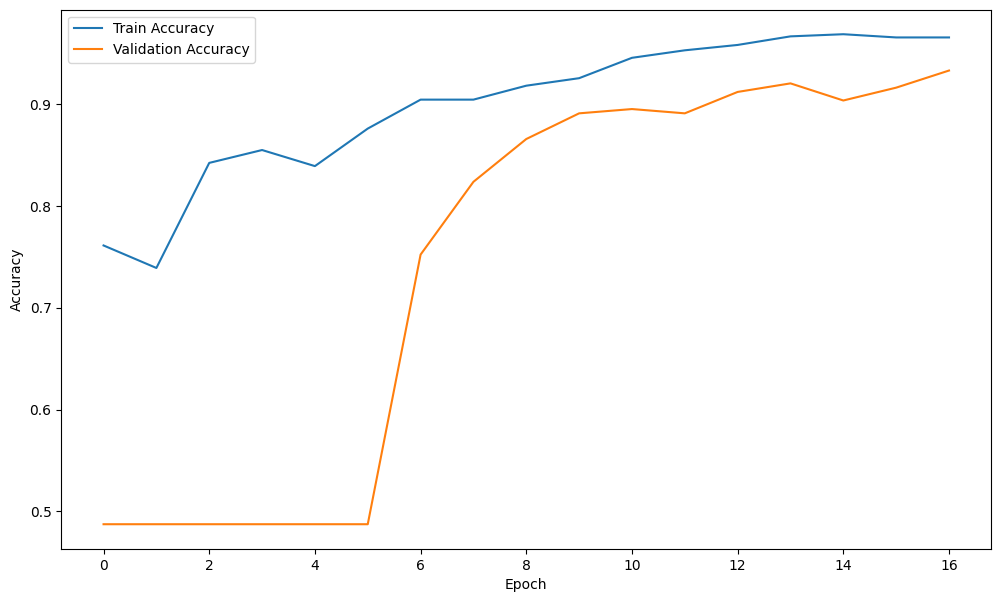

In [7]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

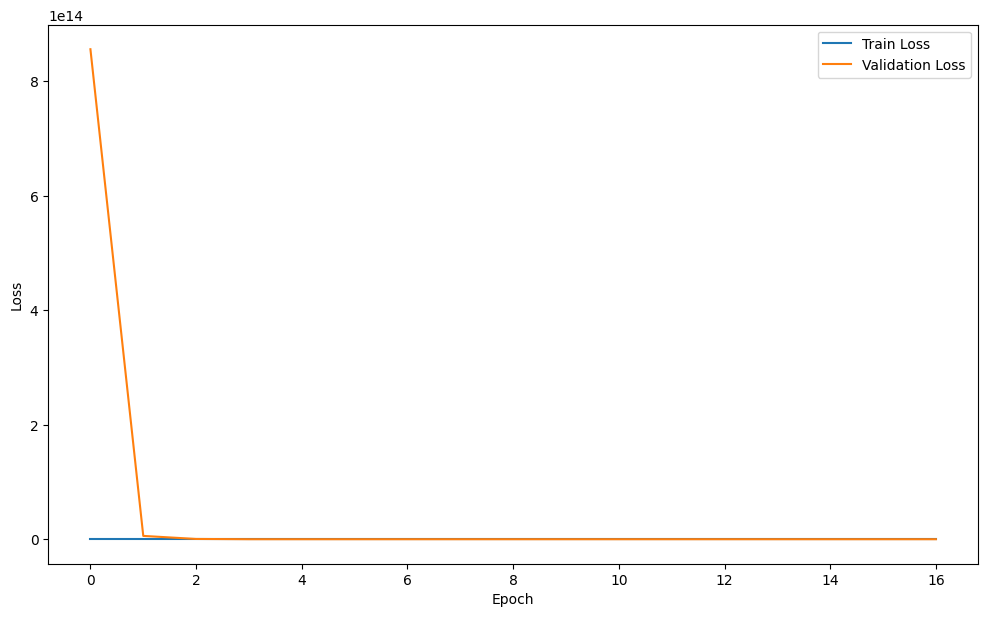

In [8]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

8/8 [==============================] - 5s 229ms/step


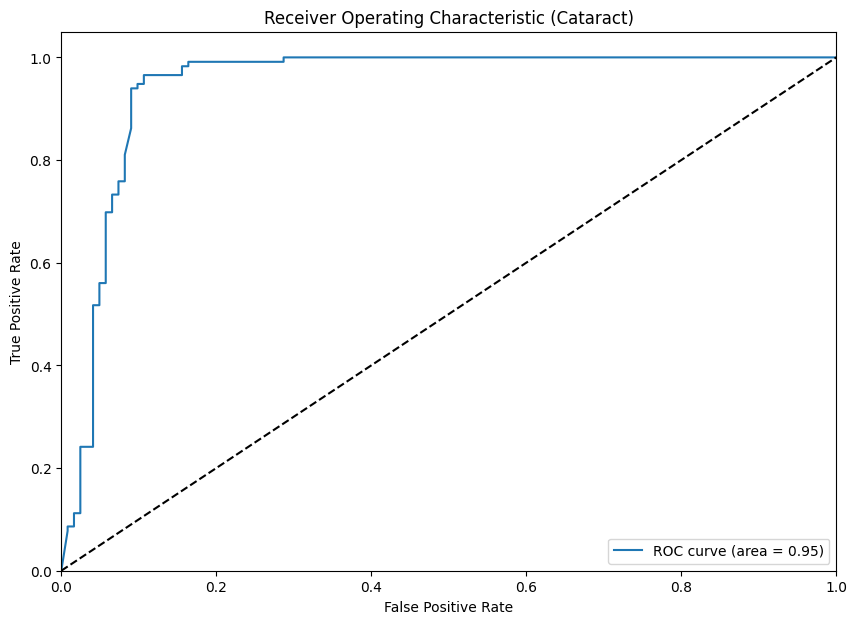

In [10]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.95      0.89      0.92       122
    Cataract       0.89      0.95      0.92       116

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238



8/8 [==============================] - 2s 215ms/step - loss: 0.5434 - accuracy: 0.9202
Test Loss: 0.5433814525604248
Test Accuracy: 0.9201680421829224


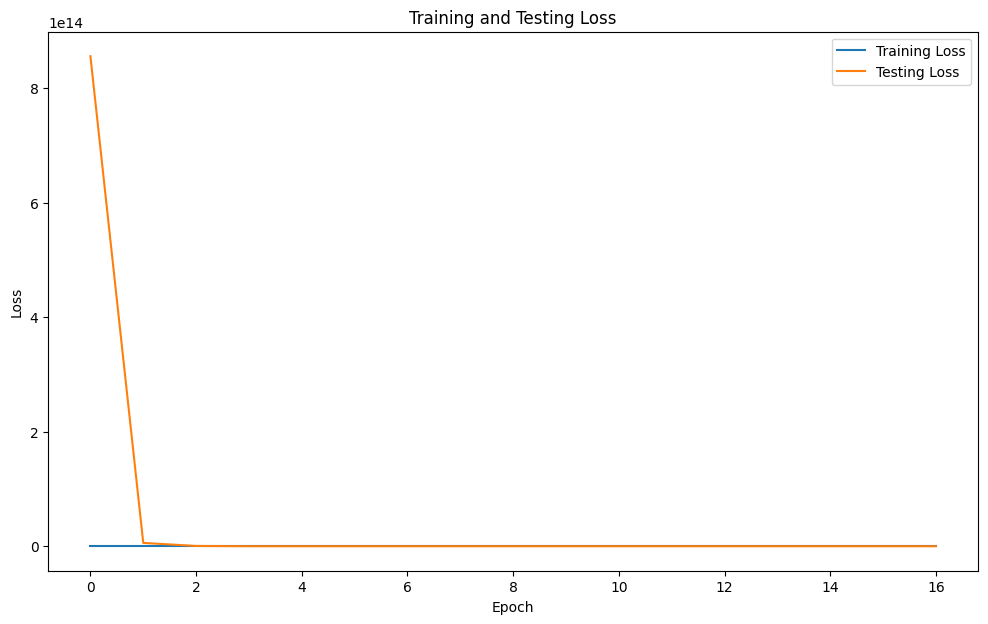

In [12]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

In [13]:
# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')

Training Time: 606.0368037223816 seconds


## **DenseNet-169**

In [15]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained DenseNet-169 model
densenet = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on DenseNet-169
model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_2 (Flatten)         (None, 81536)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               20873472  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33,516,609
Trainable params: 33,358,209
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/20
30/30 [==================

In [16]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 111ms/step - loss: 0.1701 - accuracy: 0.9286
Test Loss: 0.17010407149791718
Test Accuracy: 0.9285714030265808


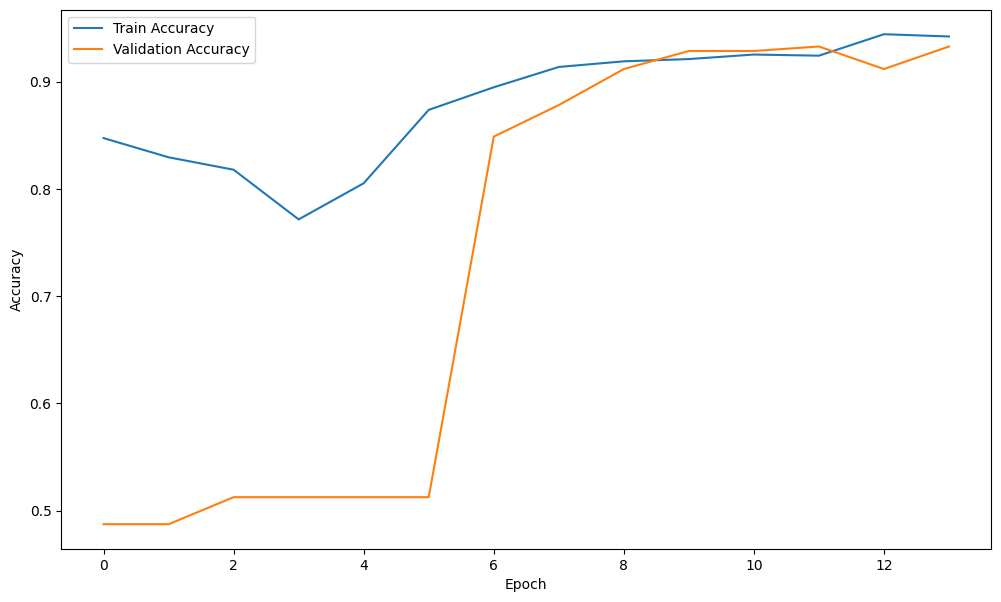

In [17]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

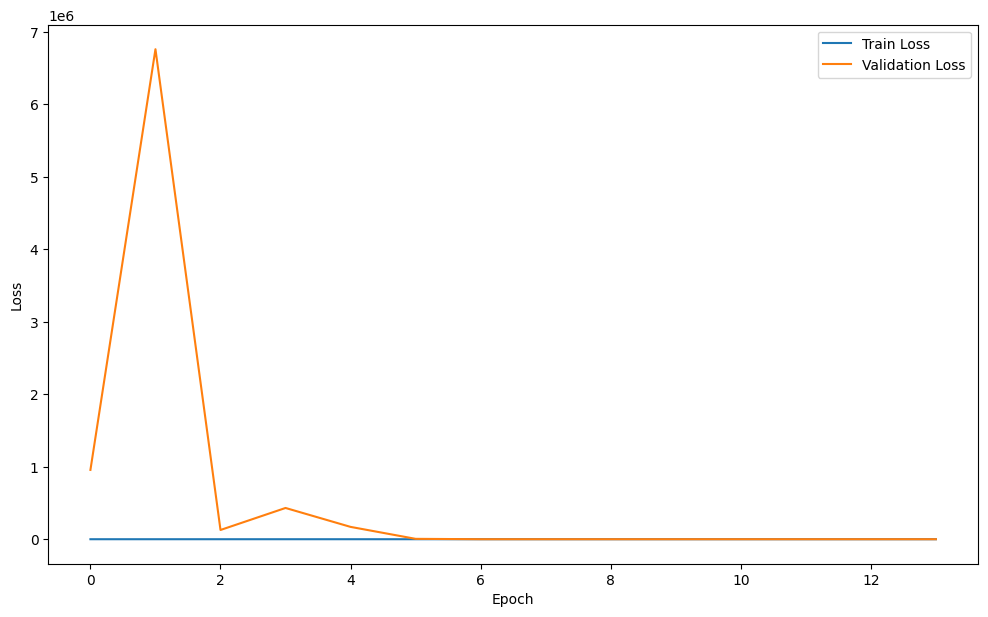

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

8/8 [==============================] - 4s 117ms/step


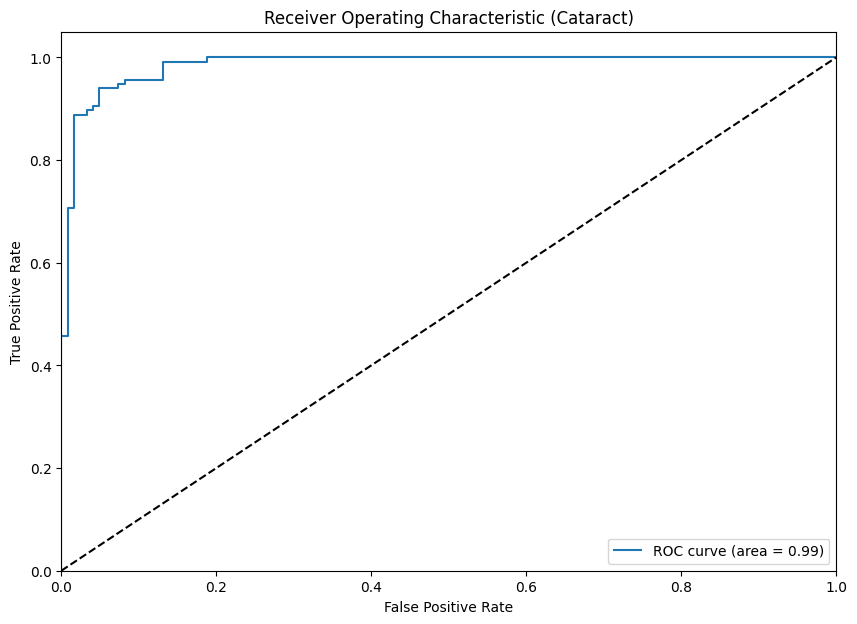

In [20]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.96      0.90      0.93       122
    Cataract       0.90      0.96      0.93       116

    accuracy                           0.93       238
   macro avg       0.93      0.93      0.93       238
weighted avg       0.93      0.93      0.93       238



In [22]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 106ms/step - loss: 0.1701 - accuracy: 0.9286
Test Loss: 0.17010407149791718
Test Accuracy: 0.9285714030265808


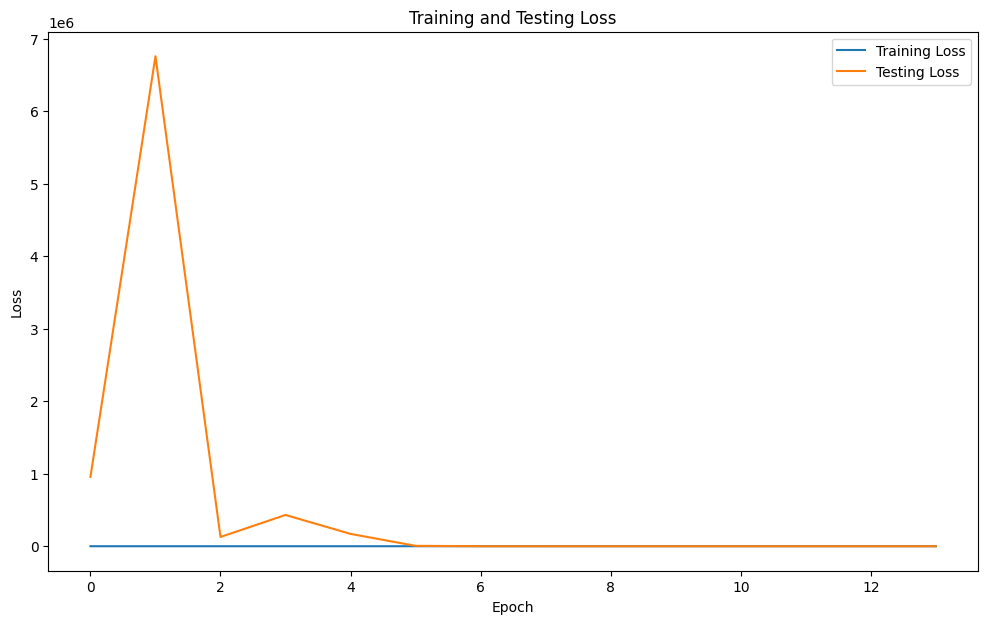

Training Time: 320.4319508075714 seconds


In [23]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')

## **VGG-19 Hyperparameter**

In [24]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [26]:
# Start the timer
start_time = time.time()

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test), verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 1.3480 - accuracy: 0.8800

30/30 [==============================] - 14s 433ms/step - loss: 1.3480 - accuracy: 0.8800 - val_loss: 1.1893 - val_accuracy: 0.9454
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9737

30/30 [==============================] - 6s 208ms/step - loss: 0.1682 - accuracy: 0.9737 - val_loss: 0.9411 - val_accuracy: 0.9370
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9832

30/30 [==============================] - 6s 211ms/step - loss: 0.0800 - accuracy: 0.9832 - val_loss: 0.9190 - val_accuracy: 0.9370
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9884

30/30 [==============================] - 6s 212ms/step - loss: 0.0515 - accuracy: 0.9884 - val_loss: 1.1150 - val_accuracy: 0.9412
Epoch 5/20
30/30 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9979

30/30 [==============================] - 6s 213ms/step - loss: 0.0035 - accuracy: 0.9979 - val_loss: 0.9729 - val_accuracy: 0.9538
Epoch 6/20
30/30 [==============================] - ETA: 0s - loss: 1.6623e-04 - accuracy: 1.0000

30/30 [==============================] - 6s 212ms/step - loss: 1.6623e-04 - accuracy: 1.0000 - val_loss: 0.9529 - val_accuracy: 0.9580
Epoch 7/20
30/30 [==============================] - ETA: 0s - loss: 1.0604e-04 - accuracy: 1.0000

30/30 [==============================] - 6s 207ms/step - loss: 1.0604e-04 - accuracy: 1.0000 - val_loss: 0.9630 - val_accuracy: 0.9580
Epoch 8/20
30/30 [==============================] - ETA: 0s - loss: 8.5070e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 208ms/step - loss: 8.5070e-05 - accuracy: 1.0000 - val_loss: 0.9669 - val_accuracy: 0.9580
Epoch 9/20
30/30 [==============================] - ETA: 0s - loss: 7.5799e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 205ms/step - loss: 7.5799e-05 - accuracy: 1.0000 - val_loss: 0.9715 - val_accuracy: 0.9538
Epoch 10/20
30/30 [==============================] - ETA: 0s - loss: 6.7343e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 205ms/step - loss: 6.7343e-05 - accuracy: 1.0000 - val_loss: 0.9711 - val_accuracy: 0.9538
Epoch 11/20
30/30 [==============================] - ETA: 0s - loss: 6.1148e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 204ms/step - loss: 6.1148e-05 - accuracy: 1.0000 - val_loss: 0.9725 - val_accuracy: 0.9496
Epoch 12/20
30/30 [==============================] - ETA: 0s - loss: 5.6499e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 201ms/step - loss: 5.6499e-05 - accuracy: 1.0000 - val_loss: 0.9712 - val_accuracy: 0.9538
Epoch 13/20
30/30 [==============================] - ETA: 0s - loss: 5.2632e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 203ms/step - loss: 5.2632e-05 - accuracy: 1.0000 - val_loss: 0.9736 - val_accuracy: 0.9496
Epoch 14/20
30/30 [==============================] - ETA: 0s - loss: 4.9494e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 208ms/step - loss: 4.9494e-05 - accuracy: 1.0000 - val_loss: 0.9749 - val_accuracy: 0.9496
Epoch 15/20
30/30 [==============================] - ETA: 0s - loss: 4.6358e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 204ms/step - loss: 4.6358e-05 - accuracy: 1.0000 - val_loss: 0.9749 - val_accuracy: 0.9496
Epoch 16/20
30/30 [==============================] - ETA: 0s - loss: 4.3692e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 206ms/step - loss: 4.3692e-05 - accuracy: 1.0000 - val_loss: 0.9749 - val_accuracy: 0.9496
Epoch 17/20
30/30 [==============================] - ETA: 0s - loss: 4.1870e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 207ms/step - loss: 4.1870e-05 - accuracy: 1.0000 - val_loss: 0.9746 - val_accuracy: 0.9496
Epoch 18/20
30/30 [==============================] - ETA: 0s - loss: 3.9493e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 207ms/step - loss: 3.9493e-05 - accuracy: 1.0000 - val_loss: 0.9770 - val_accuracy: 0.9496
Epoch 19/20
30/30 [==============================] - ETA: 0s - loss: 3.7425e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 206ms/step - loss: 3.7425e-05 - accuracy: 1.0000 - val_loss: 0.9789 - val_accuracy: 0.9496
Epoch 20/20
30/30 [==============================] - ETA: 0s - loss: 3.5649e-05 - accuracy: 1.0000

30/30 [==============================] - 6s 206ms/step - loss: 3.5649e-05 - accuracy: 1.0000 - val_loss: 0.9797 - val_accuracy: 0.9496


In [27]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

8/8 [==============================] - 1s 145ms/step - loss: 0.9797 - accuracy: 0.9496
loss: 0.979705274105072
Accuracy: 0.9495798349380493


In [28]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 144ms/step - loss: 0.9797 - accuracy: 0.9496
Test Loss: 0.979705274105072
Test Accuracy: 0.9495798349380493


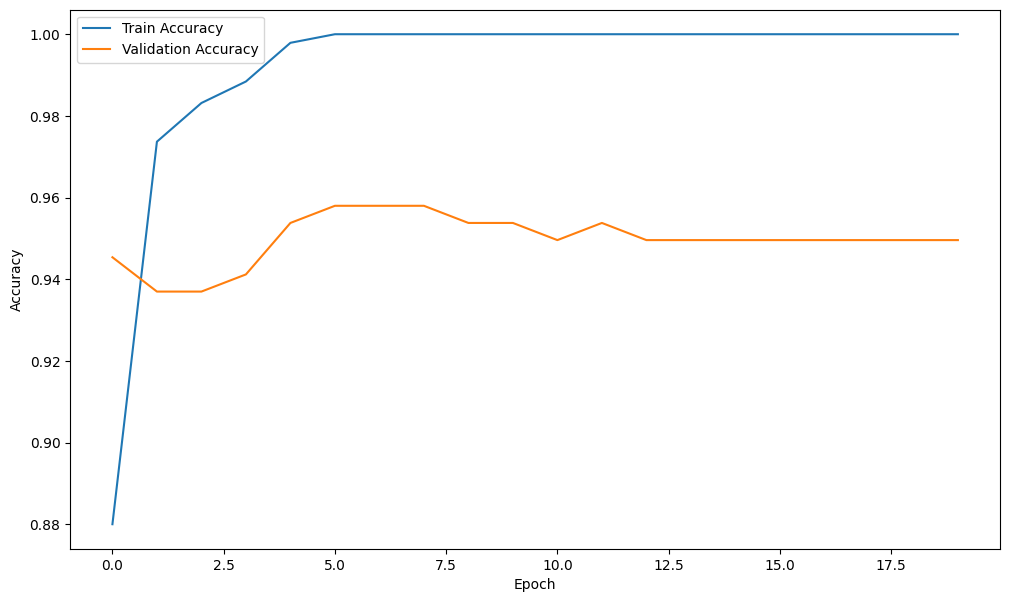

In [29]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

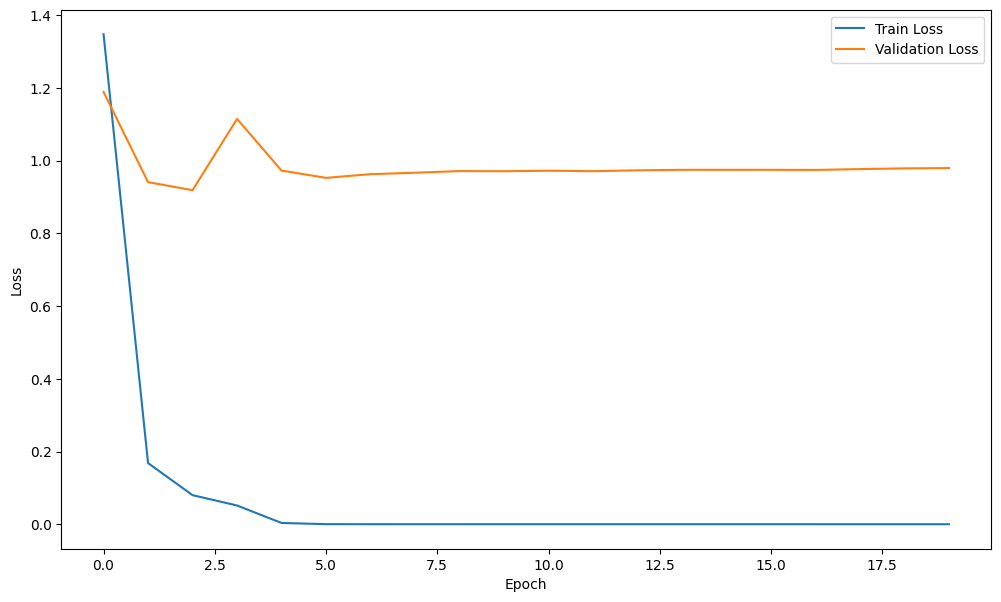

In [30]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

8/8 [==============================] - 1s 153ms/step


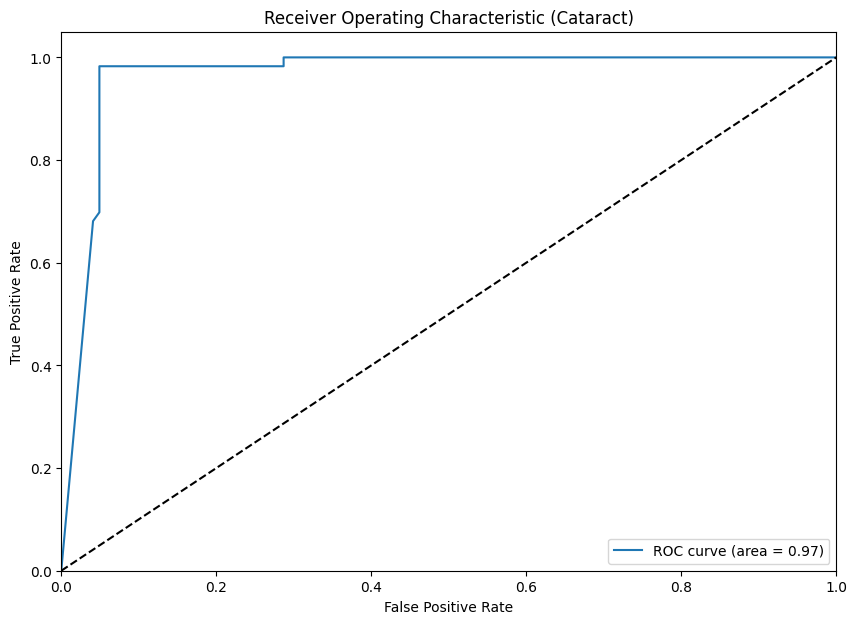

In [32]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [33]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95       122
    Cataract       0.92      0.98      0.95       116

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



In [34]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 147ms/step - loss: 0.9797 - accuracy: 0.9496
Test Loss: 0.979705274105072
Test Accuracy: 0.9495798349380493


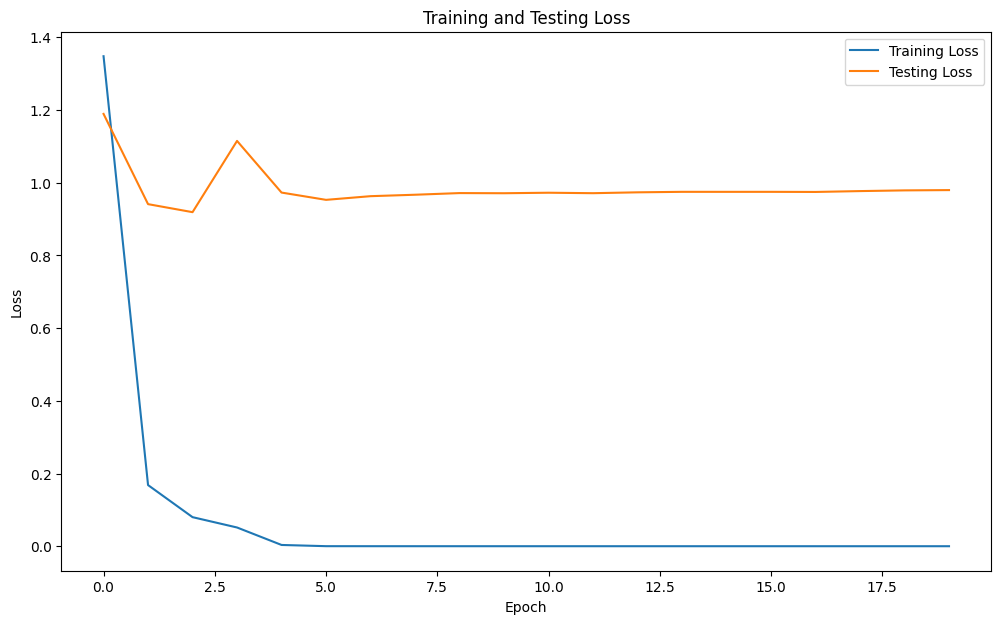

In [35]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

In [36]:
# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')

Training Time: 152.00908875465393 seconds
